下图展现了LIME算法背后的基本思想。对于数据集中每个（x1，x2）对，下图中的浅灰色区域和深灰色区域显示了此分类模型的决策边界，浅灰色区域为一类，深灰色区域为另一类。 LIME能够为单个点的分类预测提供解释（下图中蓝点）。通过在要解释的点的周围生成新的扰动数据集（蓝色点周围的彩色标记）来创建说明。每个生成的扰动都可用机器学习模型（决策边界内外的彩色标记）来预测其输出或类别。每个扰动的重要性是通过测量其与待解释的原始实例的距离来确定的。通过使用内核函数将距离映射到零/一标度，可以将这些距离转换为权重（有关权重，请参见颜色标度）。所有的这些信息：新生成的数据集，其类别预测及其权重便可用于拟合简单的模型，例如线性模型（蓝线），从而生成解释性。

<center><div>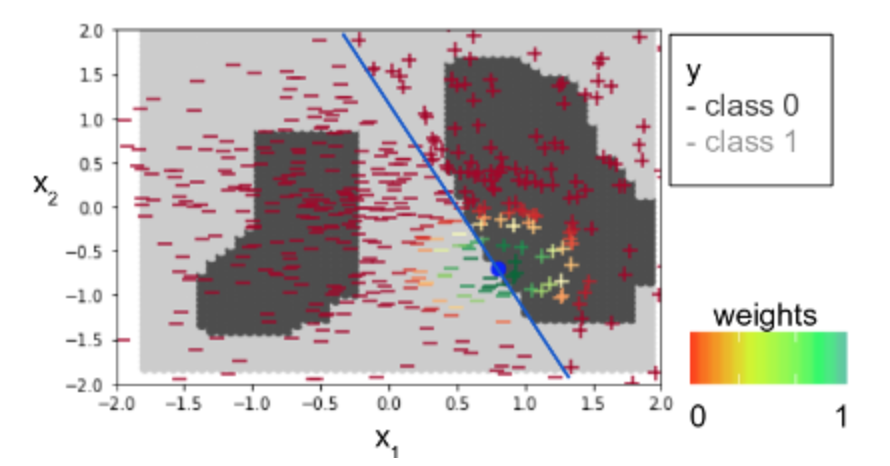</div></center>

这里将用类似的思维方式来解释InceptionV3网络的图像识别结果。

### 步骤1 安装并引入必要的库

In [ ]:
!pip install scikit-image==0.16.2
!pip install tensorflow==2.0.0
!pip install numpy==1.16.0

In [1]:
import numpy as np

import skimage
from skimage import io
from skimage import transform
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.imagenet_utils import decode_predictions

import skimage.segmentation
import copy
import sklearn.metrics
from sklearn.linear_model import LinearRegression

### 步骤2 载入图片并进行预处理

In [2]:
#读取图片像素数据
Xi = skimage.io.imread(fname = "wolf.jpg")

In [3]:
#对像素数据进行预处理
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2

```python 
np.random.seed(222)
#载入InceptionV3模型
inceptionV3_model = keras.applications.inception_v3.InceptionV3(weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5') 
#用InceptionV3模型来识别载入的图片
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
#保存分类可能性最高的五类
top_pred_classes = preds[0].argsort()[-5:][::-1]
#查看这五类的名称和可能性
decode_predictions(preds)[0]
```

<div class="alert alert-success alertsuccess" style="margin-top: 10px">
☞ 轮到你了：
</div>

In [5]:
np.random.seed(222)
#载入InceptionV3模型
inceptionV3_model = keras.applications.inception_v3.InceptionV3(weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5') 
#用InceptionV3模型来识别载入的图片
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
#保存分类可能性最高的五类
top_pred_classes = preds[0].argsort()[-5:][::-1]
#查看这五类的名称和可能性
decode_predictions(preds)[0]

[('n02114367', 'timber_wolf', 0.8590078),
 ('n02114712', 'red_wolf', 0.057871517),
 ('n02114855', 'coyote', 0.011716401),
 ('n02114548', 'white_wolf', 0.003801312),
 ('n02115641', 'dingo', 0.003285587)]

可以看到InceptionV3模型对"wolf.jpg"的识别结果为：<br>
85.90%的可能性为大灰狼，<br>
5.79%的可能性为红狼，<br>
1.17%的可能性为土狼，<br>
0.38%的可能性为白狼，<br>
0.33%的可能性为澳洲野犬。<br>
可见InceptionV3模型的识别准确率还不错，在接下来的步骤中我们将探索InceptionV3模型是如何对图像进行识别的。

### 步骤3 分割超像素块并随机抽取

In [6]:
#分割图片创建超像素
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
#定义超像素块的数量
num_superpixels = np.unique(superpixels).shape[0]

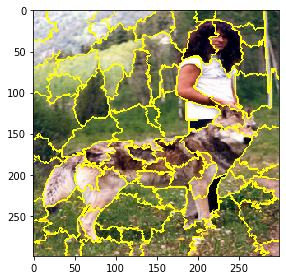

In [8]:
#阅览分块完成后的图
%matplotlib inline
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

在以上图像中我们可以看到，原图像被分割成了71（num_superpixels=71）片超像素。

In [9]:
#定义扰乱的次数
num_perturb = 150
#建立长度为71的0/1随机数列
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#定义公式，在原图像上随机选取像素块
def perturb_image(img,perturbation,segments): 
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

[1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1
 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1]


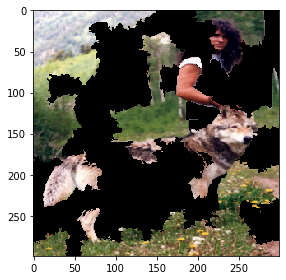

In [10]:
#可视化扰乱图像
print(perturbations[0]) 
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

### 步骤4 用机器学习分类器对分割后的图进行分类预测

In [11]:
predictions = []
#用inceptionV3模型对每一张扰乱图像进行识别，并将结果存入predictions列表
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)
predictions = np.array(predictions)

### 步骤5 计算原图与随机扰动图之间的距离

In [12]:
#计算原图像与扰乱图像之间的距离
original_image = np.ones(num_superpixels)[np.newaxis,:] 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

In [13]:
#定义核长度为0.25
kernel_width = 0.25
#用核函数计算权重
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) 

### 步骤6 拟合模型

In [14]:
#原图的预测结果，即大灰狼
class_to_explain = top_pred_classes[0] 
#选择一个简单模型，此处使用线性回归
simpler_model = LinearRegression()
#拟合模型
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
#读取参数
coeff = simpler_model.coef_[0]

### 步骤7 可视化解释结果

In [15]:
#从线性模型中提取最主要的特征
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

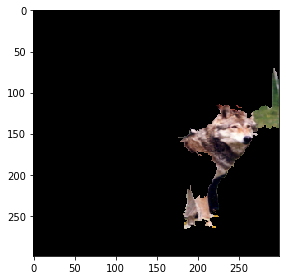

In [16]:
#建立与超像素块值相同的遮罩
mask = np.zeros(num_superpixels) 
#在主要特征所在的超像素块处显示图像
mask[top_features]= True 
#可视化识别的解释结果
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))

在上图中我们可以发现，InceptionV3模型不光能提供较高的识别准确率，而且它的识别结果是建立在相对准确的图像块上的（上图中的非遮盖部位）。